In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit 
using Plots, LaTeXStrings
using DelimitedFiles, DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
include("VirusLoadCurve.jl")
using .VirusLoadCurve

In [4]:
io = IOBuffer(append=true)
print(io, @sprintf "\nData & \$\\mx\$ & \$\\mn\$ & \$a_1\$ & \$a_2\$ & \$\\alpha\$ & \$b_1\$ & \$b_2\$ \\\\ \n")
function VLFResultsLatex(dataname, result)
    print(io, @sprintf "%s & " dataname)
    print(io, @sprintf "%.2f \$\\cdot 10^{%d}\$ & " 10^rem(result.fit.param[6], 1) floor(result.fit.param[6]))
    print(io, @sprintf "\$10^{-7}\$ & ")
    print(io, @sprintf "%.2f & " result.fit.param[1])
    print(io, @sprintf "%.2f & " result.fit.param[2])
    print(io, @sprintf "%.2f & " result.fit.param[5])
    print(io, @sprintf "%.2f & " result.fit.param[3])
    print(io, @sprintf "%.2f \\\\ \n" result.fit.param[4])
end

VLFResultsLatex (generic function with 1 method)

# Viral load data fitting

Macaque monkies data from

*Chandrashekar, A., Liu, J., Martinot, A. J., McMahan, K., Mercado, N. B., Peter, L., Tostanoski, L. H., Yu, J., Maliga, Z., Nekorchuk, M., Busman-Sahay, K., Terry, M., Wrijil, L. M., Ducat, S., Martinez, D. R., Atyeo, C., Fischinger, S., Burke, J. S., Slein, M. D., … Barouch, D. H. (2020). SARS-CoV-2 infection protects against rechallenge in rhesus macaques. Science, 817(August), eabc4776. https://doi.org/10.1126/science.abc4776*


## Data set

3 data sets from nasal swab (NS) samples with 10 observations and 3 data sets from 3 data sets from bronchoalveolar lavage (BAL) with 7 observations, each with 3 individuals.

In [5]:
RAWDATA = Dict()
path = "../../data/Chandrashekar2020/"
foreach(filter(x->occursin(".csv", x), readdir(path))) do file
    temp = readdlm(path*file, ',', Float64, '\n', header=true)
    RAWDATA[file[1:end-4]] = DataFrame(temp[1], Symbol.(temp[2][:]))
end
for k in keys(RAWDATA)
    display("Data: "*k)
    display(RAWDATA[k])
end

"Data: Group 3 (NS)"

,0,1,2,4,7,10,14,21,28,35
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.69897,5.57957,6.78347,6.52007,5.68887,5.00241,3.71236,3.99145,1.69897,1.69897
2,1.69897,3.73932,5.05975,2.46123,1.69897,1.69897,1.69897,1.69897,1.69897,1.69897
3,1.69897,3.60011,6.78389,5.70977,6.19306,5.36131,2.80269,1.69897,1.94787,1.69897


"Data: Group 1 (BAL)"

,1,2,4,7,10,14,21
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,8.4688,8.16525,6.23715,5.12414,3.3126,1.69897,1.69897
2,4.14981,5.00692,5.32055,2.65836,1.69897,1.69897,1.69897
3,6.26342,5.88252,3.67602,1.99093,1.69897,1.69897,1.69897


"Data: Group 2 (BAL)"

,1,2,4,7,10,14,21
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,6.8212,6.5641,3.83382,3.22656,2.16679,1.69897,1.69897
2,5.73113,7.31209,4.65007,4.31562,2.06809,2.82957,1.69897
3,8.02753,8.96746,6.95217,5.19312,4.95855,1.69897,1.69897


"Data: Group 2 (NS)"

,0,1,2,4,7,10,14,21,28,35
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.69897,4.6673,6.9958,6.4588,6.55061,5.1867,3.30582,2.85234,1.69897,1.69897
2,1.69897,7.08751,7.09246,5.72399,5.83477,3.66631,3.62261,1.69897,1.69897,1.69897
3,1.69897,6.33338,8.16723,7.13837,5.33877,2.94954,1.69897,1.69897,1.69897,1.69897


"Data: Group 1 (NS)"

,0,1,2,4,7,10,14,21,28,35
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.69897,7.43565,7.85023,6.96461,6.20642,5.21971,4.42147,3.39755,2.65476,1.69897
2,1.69897,6.92311,8.54628,6.57286,6.20234,3.89381,3.59259,2.33387,2.11574,1.69897
3,1.69897,6.62817,6.34402,5.29559,1.69897,2.97788,1.69897,1.69897,1.69897,1.69897


"Data: Group 3 (BAL)"

,1,2,4,7,10,14,21
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,6.15544,4.71935,3.45758,5.38309,4.78797,4.47411,1.69897
2,5.29566,7.90372,4.85545,4.21351,1.69897,1.69897,1.69897
3,5.725,5.74933,4.52692,3.91309,1.69897,1.69897,1.69897


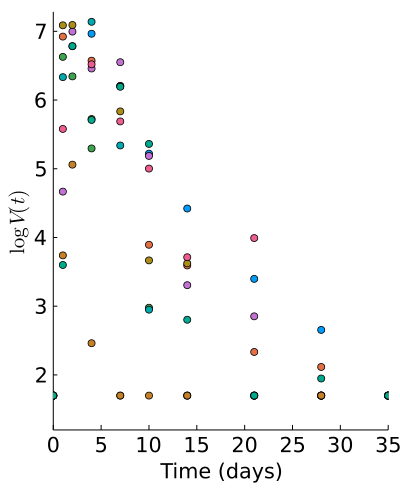

In [6]:
plt = plot(legend=:none)
for dataname in ["Group 1 (NS)", "Group 2 (NS)", "Group 3 (NS)"]
    for monkey in [1, 2, 3]
        ttdata = parse.(Float64, names(RAWDATA[dataname]))
        vvdata = Array(RAWDATA[dataname])[monkey, :]
        data = VirusLoadCurve.VirusLoadData(ttdata, vvdata)
        plot!(plt, data, size = (400, 500))
    end
end
savefig(figdir*"Chandrashekar2020Data.pdf")
display(plt)

## Fitting the standard virus load function to each individual in all groups (nasal swab)

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:11
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


Number of possible parameter found: 27507
Group 1 (NS), monkey no.: 1
RSS = 3.17784e+00
a₁ = 0.0, CI=(

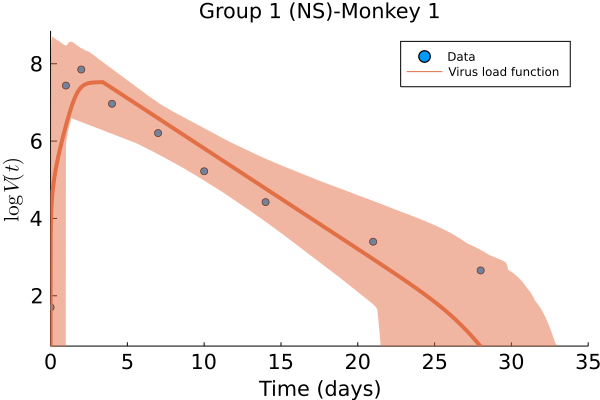

6.588836434992612e-6, 0.9965613958793315)
a₂ = 3.4059510821873267, CI=(0.02113617552097491, 3.7105766563608173)
b₁ = 19.539191565715424, CI=(5.732548448281616, 33.59901260974053)
b₂ = 35.0, CI=(21.55707905080066, 34.99996427955084)
α = 0.5985678829659272, CI=(0.302715055482222, 0.7613512407195613)
logVmax = 7.525694996338918, CI=(6.657258691962761, 8.70604886247854)





Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:08
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


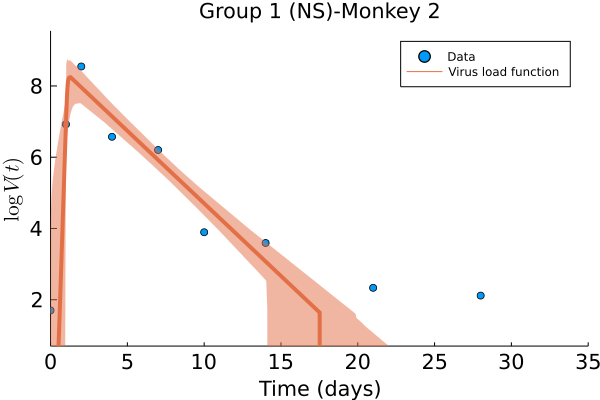

Number of possible parameter found: 3915
Group 1 (NS), monkey no.: 2
RSS = 2.24921e+00
a₁ = 0.9006700477734312, CI=(0.0010136096008516171, 0.9950453346219921)
a₂ = 1.2979004683193613, CI=(1.0332796834592868, 2.7117870201401617)
b₁ = 17.528298359941992, CI=(6.571695236319618, 28.87095711688189)
b₂ = 17.528298359941992, CI=(14.114970705852365, 31.906660841271332)
α = 0.9377871363302045, CI=(0.7797478979270462, 1.0939918107426712)
logVmax = 8.246812337297394, CI=(7.520196539761497, 8.746573071400235)





Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:09
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


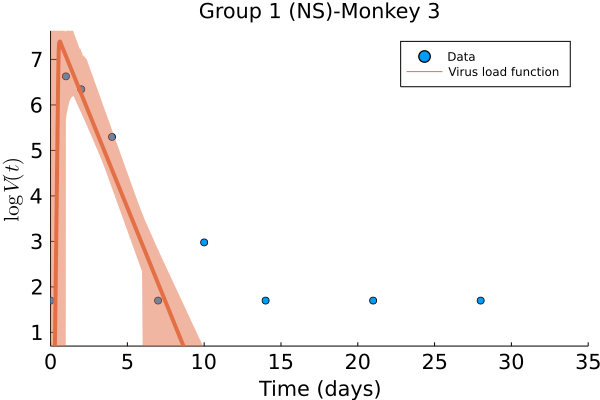

Number of possible parameter found: 22703
Group 1 (NS), monkey no.: 3
RSS = 2.50640e+00
a₁ = 0.4306090096395687, CI=(4.613018537824587e-6, 0.9974408407719194)
a₂ = 0.6167630036778908, CI=(0.009021121690232614, 2.4979279217871833)
b₁ = 15.21936075922235, CI=(1.820167726172924, 28.91699289999002)
b₂ = 15.21936075922235, CI=(5.999958965771114, 30.755297903137617)
α = 1.917973669161064, CI=(1.6075929025013767, 2.3225902011617086)
logVmax = 7.393324603017457, CI=(6.2108541729980615, 8.427766613939717)





Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:15
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


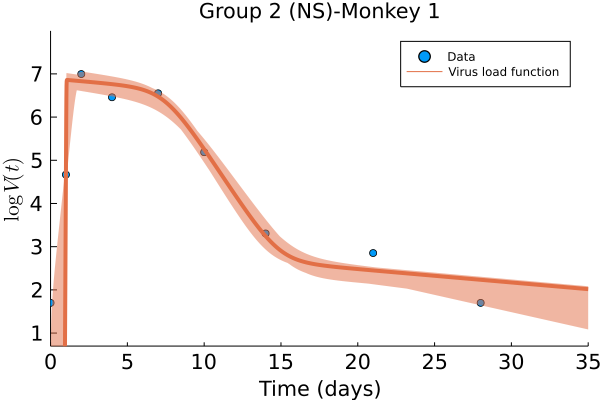

Number of possible parameter found: 24
Group 2 (NS), monkey no.: 1
RSS = 6.82183e-01
a₁ = 0.9938142693823137, CI=(0.8203423294902712, 1.008083919267126)
a₂ = 1.072704645122845, CI=(1.0396761319379815, 2.427631813669859)
b₁ = 2.3288961627431, CI=(1.3315785817835422, 2.9332727848989695)
b₂ = 12.543596175834706, CI=(11.926026315825672, 14.21178850477969)
α = 0.07123236840576606, CI=(0.05528191699441415, 0.1841809952627143)
logVmax = 6.860140321319586, CI=(6.639399994405405, 7.050672363733335)





Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:15
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


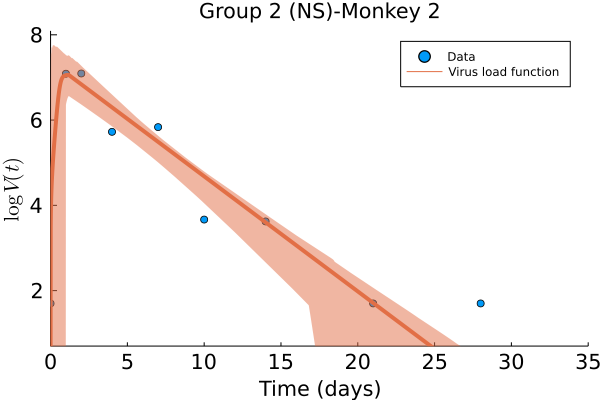

Number of possible parameter found: 12377
Group 2 (NS), monkey no.: 2
RSS = 1.54322e+00
a₁ = 0.0, CI=(6.644957149043271e-6, 0.9963489739637338)
a₂ = 1.1792037141196858, CI=(0.009521344734565007, 2.202184479507188)
b₁ = 25.771459528951826, CI=(12.213650339171204, 34.99954604251704)
b₂ = 27.13195970658068, CI=(17.53655473756094, 34.999638659853396)
α = 0.6212889593785014, CI=(0.535801967577933, 0.8430128269555335)
logVmax = 7.060909325302576, CI=(6.58127438287361, 7.762067222311805)





Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:12
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


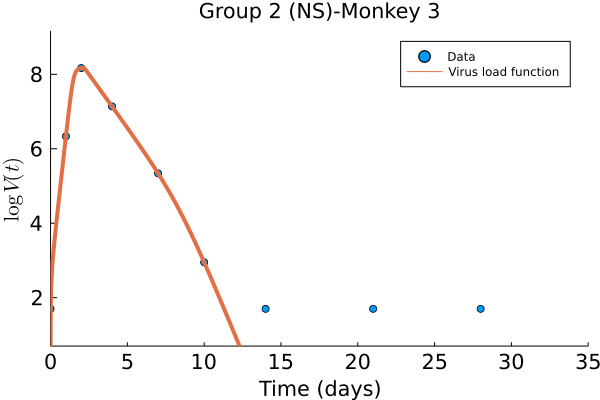

Number of possible parameter found: 0
Group 2 (NS), monkey no.: 3
RSS = 2.36658e-30
a₁ = 0.7919698783111918, CI=(-Inf, Inf)
a₂ = 2.1959280594682093, CI=(-Inf, Inf)
b₁ = 2.507274665263254, CI=(-Inf, Inf)
b₂ = 14.370016226302708, CI=(-Inf, Inf)
α = 1.315075203239605, CI=(-Inf, Inf)
logVmax = 8.173492436039128, CI=(-Inf, Inf)





Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:14
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


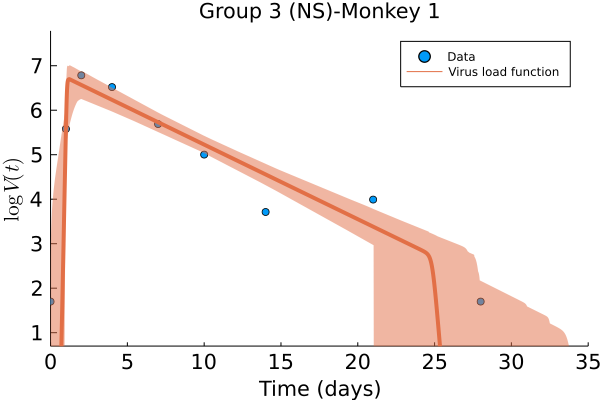

Number of possible parameter found: 1598
Group 3 (NS), monkey no.: 1
RSS = 1.26373e+00
a₁ = 0.9095803854651354, CI=(0.0006863089614073115, 0.9755848789406639)
a₂ = 1.2195464641724485, CI=(1.0626238880421608, 3.2194313800407945)
b₁ = 24.187635526997983, CI=(16.88080678251401, 34.80336500455456)
b₂ = 25.5202514042531, CI=(21.03952248648187, 34.86727531300687)
α = 0.38605713874105035, CI=(0.31288637231685323, 0.4583172724734821)
logVmax = 6.6993699980397405, CI=(6.266630315678153, 7.009873621931597)





Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:09
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


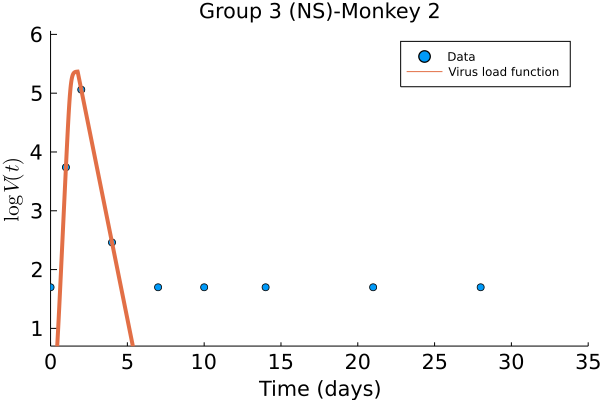

Number of possible parameter found: 0
Group 3 (NS), monkey no.: 2
RSS = 0.00000e+00
a₁ = 0.8217314352284528, CI=(-Inf, Inf)
a₂ = 1.7627467412508013, CI=(-Inf, Inf)
b₁ = 13.123861428161096, CI=(-Inf, Inf)
b₂ = 13.123861428161096, CI=(-Inf, Inf)
α = 2.9917064939112703, CI=(-Inf, Inf)
logVmax = 5.368057072635886, CI=(-Inf, Inf)





Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:23
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


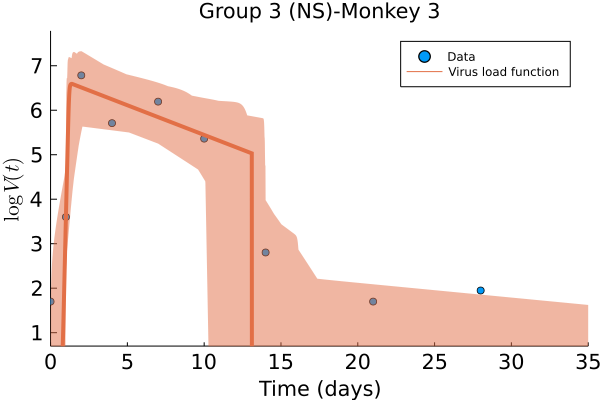

Number of possible parameter found: 2941
Group 3 (NS), monkey no.: 3
RSS = 1.76887e+00
a₁ = 1.026812352784019, CI=(0.4457737567523199, 1.4299319077196715)
a₂ = 1.3868288731130902, CI=(1.0337873042384873, 3.9486114766503952)
b₁ = 13.10837146354013, CI=(2.225856848371306, 15.881883297758893)
b₂ = 13.10837146354013, CI=(10.131014568507675, 19.555680897293822)
α = 0.30731359527344065, CI=(0.012967497184166288, 0.6390144919632501)
logVmax = 6.594337883254254, CI=(5.647346786300662, 7.3283719728523735)





In [7]:
params = []
for dataname in ["Group 1 (NS)", "Group 2 (NS)", "Group 3 (NS)"]
    for monkey in [1, 2, 3]
        ttdata = parse.(Float64, names(RAWDATA[dataname]))
        vvdata = Array(RAWDATA[dataname])[monkey, :]
        data = VirusLoadCurve.VirusLoadData(ttdata, vvdata)
        resultVLF = VirusLoadCurve.fitVLF(data; ϵ=0.2)
        params = vcat(params, resultVLF.fit.param)
        println(dataname, ", monkey no.: ", monkey)
        summary(resultVLF)
#         VLFResultsLatex(dataname*" monkey "*string(monkey), resultVLF)
        pt = plot(data)
        plot!(pt, resultVLF)
        title!(pt, dataname*"-Monkey "*string(monkey))
#         plot!(pt, legend=false)
        savefig(figdir*"Chandrashekar2020-"*dataname*"-"*string(monkey)*".png")
        savefig(figdir*"Chandrashekar2020-"*dataname*"-"*string(monkey)*".pdf")
        display(pt)
        println("\n\n")
    end
end
# print(read(io, String))
# params = reshape(params, (6, 9))

In [8]:
# parnames = ["a₁", "a₂", "b₁", "b₂", "α", "logVmax"]
# [display(histogram(params[i, :], bins=9, leg=false, title=parnames[i])) for i in 1:6]